In [1]:
import numpy as np
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [2]:
df = pd.read_pickle('../../data/processed/merged/state0_new_df.pkl')
print(df.shape)

(16574, 15)


In [3]:
df = df[(df['eventType'] == 4) & (df['is_ios'] == 1)]

df = df.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventGPSSignalStrength', 'eventSensorDetectionMthd', 'source_file', 'gpsP75LateralAccel', 'gpsP95LateralAccel'])
df = df.dropna(subset=['bearingAngleChange'])
corr_matrix = df.corr()

In [4]:
df.columns

Index(['eventDurationSeconds', 'eventStartSpeed', 'eventEndSpeed',
       'gpsMedianLateralAccel', 'bearing_angular_change_per_second',
       'bearingAngleChange', 'gps_radius'],
      dtype='object')

In [5]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(df)

In [6]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(df)

/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/connieyang/Documents/GitHub/ARITY-BTT-PROJECT-1/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,5
,min_samples,None
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


In [7]:
clusterer.labels_

array([0, 0, 0, ..., 0, 0, 0], shape=(7633,))

In [8]:
clusterer.labels_.max()

np.int64(1)

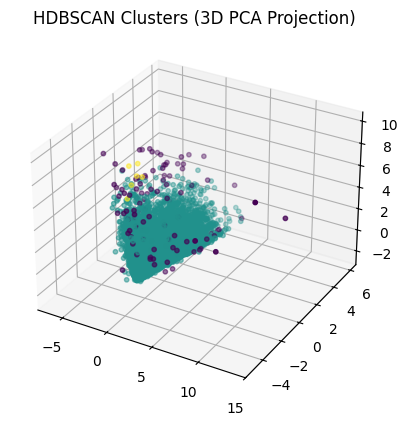

In [9]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusterer.labels_, s=10)
plt.title("HDBSCAN Clusters (3D PCA Projection)")
plt.show()

In [10]:
df['cluster']   = clusterer.labels_
df.head()

,eventDurationSeconds,eventStartSpeed,eventEndSpeed,gpsMedianLateralAccel,bearing_angular_change_per_second,bearingAngleChange,gps_radius,cluster
1155,6.989070,9.819660,9.281934,0.847049,15.546200,116.756195,23.539900,0
1156,1.952297,8.802840,8.186321,1.902596,26.772104,89.652710,7.038807,0
1157,1.952344,14.564783,17.088364,3.850459,28.404854,89.339260,11.009399,0
1190,0.923000,16.396770,16.396770,3.241720,20.187233,50.679900,17.821848,0
1196,1.965188,3.686333,2.972952,0.431327,11.213705,37.034084,6.295796,0


In [11]:
df.groupby('cluster').mean()

,eventDurationSeconds,eventStartSpeed,eventEndSpeed,gpsMedianLateralAccel,bearing_angular_change_per_second,bearingAngleChange,gps_radius
cluster,,,,,,,
-1,6.749791,11.201177,14.606449,2.856322,34.583512,179.076291,22.512880
0,2.822013,11.540784,13.730426,2.484038,24.749164,82.442517,16.866627
1,12.958059,7.121766,13.097362,1.595318,10.619900,244.646528,16.264726


cluster
-1    0.000000
 0    0.994347
 1    0.994755
Name: probability, dtype: float64


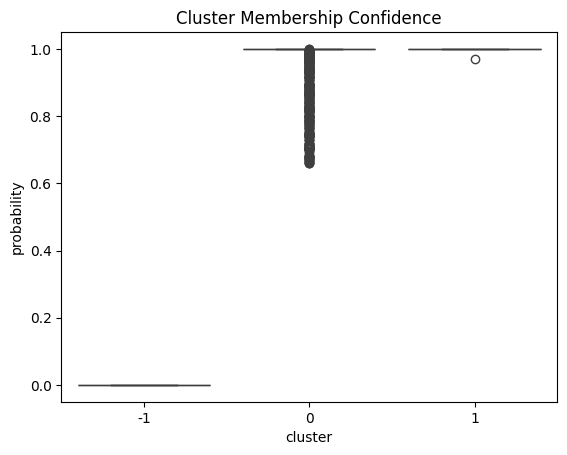

In [12]:
df['probability'] = clusterer.probabilities_
print(df.groupby('cluster')['probability'].mean())

sns.boxplot(x='cluster', y='probability', data=df)
plt.title("Cluster Membership Confidence")
plt.show()


In [13]:
df['cluster'].value_counts()

cluster
 0    7520
-1     107
 1       6
Name: count, dtype: int64

In [14]:
mask = clusterer.labels_ != -1
score = silhouette_score(X_scaled[mask], clusterer.labels_[mask])
print("Silhouette Score (excluding noise):", score)


Silhouette Score (excluding noise): 0.5090180946835805
